Want to dive right in? [Download Notebook](https://github.com/easierdata/EASIER-WEBSITE-V3/blob/main/notebooks/NDVI_STAC_IPFS.ipynb)


## Introduction
In this blog post, we will introduce you to a decentralized peer-to-peer hypermedia protocol called IPFS, which can revolutionize how you handle large datasets, such as satellite imagery, for tasks like object detection and land cover classification. With its content-addressing and decentralized architecture, IPFS makes it easier to share and distribute data across a network of nodes.

For this post, we will be showcasing IPFS through the classic and timeless Normalized Difference Vegetation Index (NDVI) analysis of Landsat 9 imagery. This example is an excellent illustration of how IPFS can be used to handle geospatial data, from fetching imagery to publishing a geospatial analysis.

So, whether you're a seasoned geospatial professional or just starting, this blog post is perfect for you. Get ready to revolutionize your geospatial analyses with IPFS!

## What is IPFS?
IPFS, or InterPlanetary File System, is a peer-to-peer network protocol designed to create a decentralized and distributed web. It allows users to store and access content in a content-addressed manner, which means that the address of the content is derived from the content itself, rather than relying on a centralized server. This makes IPFS highly resilient to censorship, data loss, and other forms of centralization.

In addition, IPFS is a peer-to-peer network, meaning that data is stored and shared across multiple nodes in the network. When you query the IPFS network for a piece of content, the network returns the content from the node that is closest to you¹, resulting in faster data access and reduced load on any single node.

In this tutorial, we will not only explore how to use IPFS to fetch Landsat imagery and publish a geospatial analysis, but we'll also be setting up our own IPFS node. This allows our computer to fetch from IPFS and, if you choose, participate in the network to make the data more available for everyone.

## Advantages of Using IPFS for Geospatial Workflows
Traditionally, geospatial workflows have relied on centralized storage systems such as cloud storage providers or local file systems. However, these systems have limitations in terms of scalability, security, and availability. By contrast, IPFS provides several advantages for geospatial workflows:
1. Content-addressing
2. Decentralization
3. Censorship Resistance

### Content-addressing: 
IPFS uses content-addressing, which means that the content itself is used to derive its address. This ensures that the data is tamper-proof and verifiable, and also allows for highly efficient data retrieval.

### Decentralization: 
IPFS is a peer-to-peer network, which means that data is stored and shared across multiple nodes in the network. This ensures that the data is highly available and geographically distributed.

### Censorship Resistance:
IPFS is a peer-to-peer network, which means that data is stored and shared across multiple nodes in the network. This ensures that the data is highly available and resilient to data loss or censorship.

## How to Calculate NDVI on Landsat 9 Imagery Using IPFS - Step-by-Step Guide
Now that we understand the advantages of using IPFS, let's see how we can calculate NDVI on Landsat 9 imagery using IPFS in a Jupyter notebook. We will be using several libraries such as rasterio, matplotlib, and pystac_client.


### Environment Setup
As of this writing, the repo that houses the Python bindings for IPFS is out of date and is [looking for a maintainer](https://github.com/ipfs-shipyard/py-ipfs-http-client/issues/316). Instead, we will install the IPFS Kubo CLI and use the subprocess library to run the CLI commands. We will also need to install the IPFS daemon, which will run in the background and allow us to access the IPFS network.

1 - [Install IPFS Kubo](https://docs.ipfs.tech/install/command-line/#install-ipfs-kubo) this will allow you to interact with the IPFS network from the command line.

2 - [Install IPFS Desktop](https://docs.ipfs.tech/install/ipfs-desktop/), which will run the IPFS daemon in the background as long as the application is running. I've found this to be the easiest way to run the IPFS daemon on my Macbook. Plus you get a nice GUI to manage your IPFS node.

3 - [Set up a Jupyter Notebook environment](https://www.youtube.com/watch?v=DA6ZAHBPF1U). A convenient method for achieving this is by utilizing the Jupyter integration in Visual Studio Code.

With Jupyter, Kubo CLI, and IPFS Desktop ready, we can begin the tutorial! First, let's import the necessary libraries:

### Install Python Libraries
First, we need to install the required libraries. I reccomend using a virtual environment to install the Python libraries. Here is the [requirements.txt](https://github.com/easierdata/stac-fastapi/blob/master/samples/requirements.txt) file I used for this tutorial.

In [ ]:
python3 -m venv venv # create virtual environment
source venv/bin/activate
pip install -r requirements.txt

### Import Python Libraries


In [2]:
# Standard library imports
from io import BytesIO
import subprocess

# Third-party library imports
import numpy as np
import rasterio
from matplotlib import colors
from matplotlib import colormaps
import matplotlib.pyplot as plt
from dateutil.parser import isoparse
from PIL import Image as pil_image
from pystac_client import Client

### How did we set up the STAC API?
Before we continue with the steps to connect to the STAC API and search for Landsat 9 imagery from the Washington D.C. area, it's worth mentioning that we have set up a STAC server ourselves and populated it with IPFS CIDs for the Landsat 9 dataset. As a proof of concept, there are only 5 landsat scenes currently on the STAC server. To learn more about the technique we used for this process, you can refer to this blog post: [A New Way to Reference and Retrieve Geographic Data](https://easierdata.org/updates/2022/2022-12-02-a-new-way-to-reference-and-retrieve-geographic-data).

If you're interested in setting up your own STAC server and populating it with IPFS CIDs, you can follow the steps outlined in our [stac-fastapi GitHub repository fork](https://github.com/easierdata/stac-fastapi).

With that background, let's continue with connecting to our STAC API and searching for Landsat 9 imagery from the Washington D.C. area:

### Explore the STAC API in a GUI using the STAC Browser
Check out the STAC Browser to see our STAC catalog in action.

https://easier.umd.edu/browse/

This browser allows you to explore the STAC catalog and see the items that are available in a user-friendly interface. In the next cells, we will use the [pystac_client](https://github.com/stac-utils/pystac-client) library to programmatically search for Landsat 9 imagery from the same STAC catalog that powers the STAC browser.

### Fetch Landsat Scene from Washington D.C. Area (Or somewhere else!)
The following code connects to our STAC API instance and searches for Landsat 9 imagery by submitting a bounding box query to the STAC server. The STAC server returns a list of Landsat 9 scenes that intersect with the bounding box. Our STAC server only has ~10 scenes, so most bounding boxes will only return a single scene.

In [4]:
# Connect to STAC API and search for Landsat 9 imagery
catalog = Client.open("http://ec2-54-172-212-55.compute-1.amazonaws.com/api/v1/pgstac/")

# Washington, DC
bbox = [-76.964657, 38.978967, -76.928008, 39.002783] 

# Taj Mahal, India
# bbox = [78.039957, 27.164888, 78.045247, 27.175254]

# Christ the Redeemer, Rio de Janeiro, Brazil
# bbox = [-43.210297, -22.951625, -43.207670, -22.948875]

# Great Wall Of China (Note: The wall is more than 13,000 miles long, and the bounding box only covers a small portion of it. Here's a bounding box for the Badaling section near Beijing)
#bbox = [116.056298, 40.338204, 116.058715, 40.343322]

# Petra, Jordan
# bbox = [35.442749, 30.322058, 35.472730, 30.342304]

# Machu Picchu, Peru
# bbox = [-72.544959, -13.165088, -72.530122, -13.155547]

# Chichen Itza, Mexico
# bbox = [-88.570015, 20.682207, -88.568230, 20.684936]

# Colosseum, Rome, Italy
# bbox = [12.490827, 41.889249, 12.494162, 41.891876]


search = catalog.search(
    collections=["landsat-c2l1"],
    bbox=bbox,
)

items = search.get_all_items()
item = items[0]
properties = item.properties
print(f"This satellite image was taken by the {properties['platform']} platform on {isoparse(properties['datetime']):%c}. \n\
The image covers an area with a bounding box of {item.bbox}. \n\
The image has a resolution of {properties['proj:shape']} pixels and uses the EPSG:{properties['proj:epsg']} coordinate reference system. \n\
The percentage of cloud cover in the image is {properties['eo:cloud_cover']}% over the entire image.")
# Uncomment the line below to see the full metadata for the item
#item 

This satellite image was taken by the LANDSAT_9 platform on Sat Oct 15 15:46:53 2022. 
The image covers an area with a bounding box of [-78.19032488487748, 37.84156096889577, -75.5633382854675, 39.951439673652615]. 
The image has a resolution of [7941, 7831] pixels and uses the EPSG:32618 coordinate reference system. 
The percentage of cloud cover in the image is 0.05% over the entire image.


### The STAC Response Object

After connecting to the STAC API and searching for the Landsat 9 imagery, the JSON response (item) will include links to the assets using traditional storage (S3) and IPFS. Here is a snippet of the JSON that includes the S3 and IPFS CID:

In this example, you can see how we injected the CID into the STAC json. This modification demonstrates how IPFS can be integrated into a geospatial workflow, alongside traditional storage systems like S3.

```json
{
  "assets": {
    "red": {
      "alternate": {
        "S3": {
          "href": "s3://usgs-landsat/collection02/.../LC08_L1TP_014033_20210905_20210917_02_T1_sr_band4.tif"
        },
        "IPFS": {
          "href": "ipfs://QmTgttqUf7PvZgdSoe71j3njeEKk1hC3h22n2sQmety3To"
        }
      }
    }
  }
}
```

At this point, In a traditional workflow, you would fetch the data from the S3 bucket using the href value. However, in this tutorial, we are going to fetch the data using IPFS.

We will grab bands 4 and 5 (Red and NIR) from the scene response object :


### Fetch bands 4 and 5 from the scene (Red and NIR)

In [5]:
red_band_cid = item.assets["red"].extra_fields["alternate"]["IPFS"]["href"].split("/")[-1]
nir_band_cid = item.assets["nir08"].extra_fields["alternate"]["IPFS"]["href"].split("/")[-1]

print(f"Red band CID: {red_band_cid}")
print(f"NIR band CID: {nir_band_cid}")

Red band CID: QmTgttqUf7PvZgdSoe71j3njeEKk1hC3h22n2sQmety3To
NIR band CID: QmZkWaKSuVhFKtAwNbxSogcT6hXHMksXjhgqLu6AXHSUKq


### Fetch Bands from IPFS
Next, we will fetch the bands from IPFS using the CIDs we extracted from the STAC server earlier. Because we aren't using a native Python library to interact with IPFS, we will use the subprocess library to run the IPFS CLI commands. The [check_output](https://docs.python.org/3/library/subprocess.html#subprocess.check_output) function will return the output of the command as a byte string. We will use this output to load the Landsat bands into numpy arrays.

In [43]:
red_band = subprocess.check_output(["ipfs", "cat", red_band_cid])
nir_band = subprocess.check_output(["ipfs", "cat", nir_band_cid])

 82.62 MiB / 82.62 MiB  100.00% 0sK
 89.73 MiB / 89.73 MiB  100.00% 0s


Now that we have the landsat scene data in-memory, we will define helper functions to load the Landsat data into numpy arrays and save the NDVI plot to a buffer that we'll upload to IPFS later:

### Helper Functions

In [44]:
def load_landsat_band(band: bytes, dtype: np.dtype = np.float32) -> np.ndarray:
    with BytesIO(band) as bytes_io:
        with rasterio.open(bytes_io) as dataset:
            return dataset.read(1).astype(dtype)


def save_plot_to_buffer(plot: plt.Figure) -> bytes:
    buffer = BytesIO()
    plot.savefig(buffer, format='png')
    buffer.seek(0)
    return buffer.getvalue()

With the helper functions defined, we can load the Landsat bands into numpy arrays:

### Load the bands into a numpy array

In [45]:
red_band_4 = load_landsat_band(red_band)
nir_band_5 = load_landsat_band(nir_band)

### Calculate NDVI
Now, we can calculate the NDVI using the loaded numpy arrays. The forumula we are using for NDVI is straight from the [USGS website](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-normalized-difference-vegetation-index?qt-science_support_page_related_con=0#qt-science_support_page_related_con). We will also add a small value to the denominator to avoid divide by zero errors because there is a chance that the red and NIR bands will have the same value in a given pixel.

In [46]:
eps = 0.0001 # Avoid divide by zero errors
ndvi = (nir_band_5 - red_band_4) / (nir_band_5 + red_band_4 + eps)

### Plot NDVI
With the NDVI calculated, we can plot the NDVI image using matplotlib.

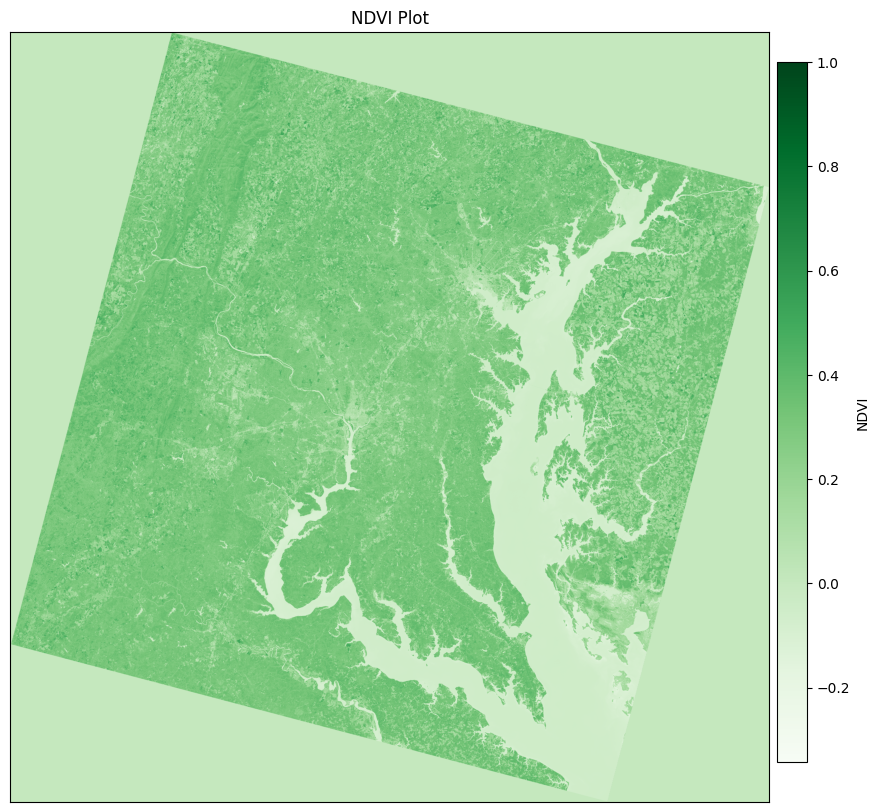

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))

# Remove the axes
ax.set_xticks([])
ax.set_yticks([])

# Set the color map to the min and max values of NDVI
ndvi_min, ndvi_max = np.min(ndvi), np.max(ndvi)
norm = colors.Normalize(vmin=ndvi_min, vmax=ndvi_max)

# Use the normalization object for the image and the color map
green_color_map = colormaps["Greens"]
green_ndvi = green_color_map(norm(ndvi))

img = ax.imshow(green_ndvi)
ax.set_title("NDVI Plot")

cax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=green_color_map), cax=cax, orientation='vertical')
cb.set_label("NDVI")

plt.show()

### Save plot to image (png) buffer
That last pieve of code should have generated a plot of the NDVI image. However, we want to save the plot to a buffer so we can add it to IPFS. We can do this by using the helper function we defined earlier. Essentially we are just 'saving' the png into memory instead of writing it to a file. That way we can upload it to IPFS without having to write it to disk.

In [48]:
plot_buffer = save_plot_to_buffer(fig)

### Add plot image to IPFS
Now, let's add the plot to our local IPFS node using the [ipfs add](https://docs.ipfs.io/reference/cli/#ipfs-add) command. The `-q` flag will return the CID hash of the added file. We will use this hash to fetch the plot image from IPFS later.

In [55]:
# Add the image buffer to IPFS and get the hash. The -q flag is used to only return the hash of the added file
plot_img_hash = subprocess.check_output(["ipfs", "add", "-q"], input=plot_buffer).decode().strip()
plot_img_hash

'QmbkCHHZJ3UoywA7DhnqFfBD6CVPUpFu7QajMg9Tp66JwL'

### Fetch plot image from IPFS and display it
Now that we have the plot saved to IPFS, we can fetch it from our local node using the CID hash. We can use the [ipfs cat](https://docs.ipfs.io/reference/cli/#ipfs-cat) command to fetch the plot image from IPFS. The output of the command will be a byte string that we can use to load the image into a PIL image object to display it in the notebook.

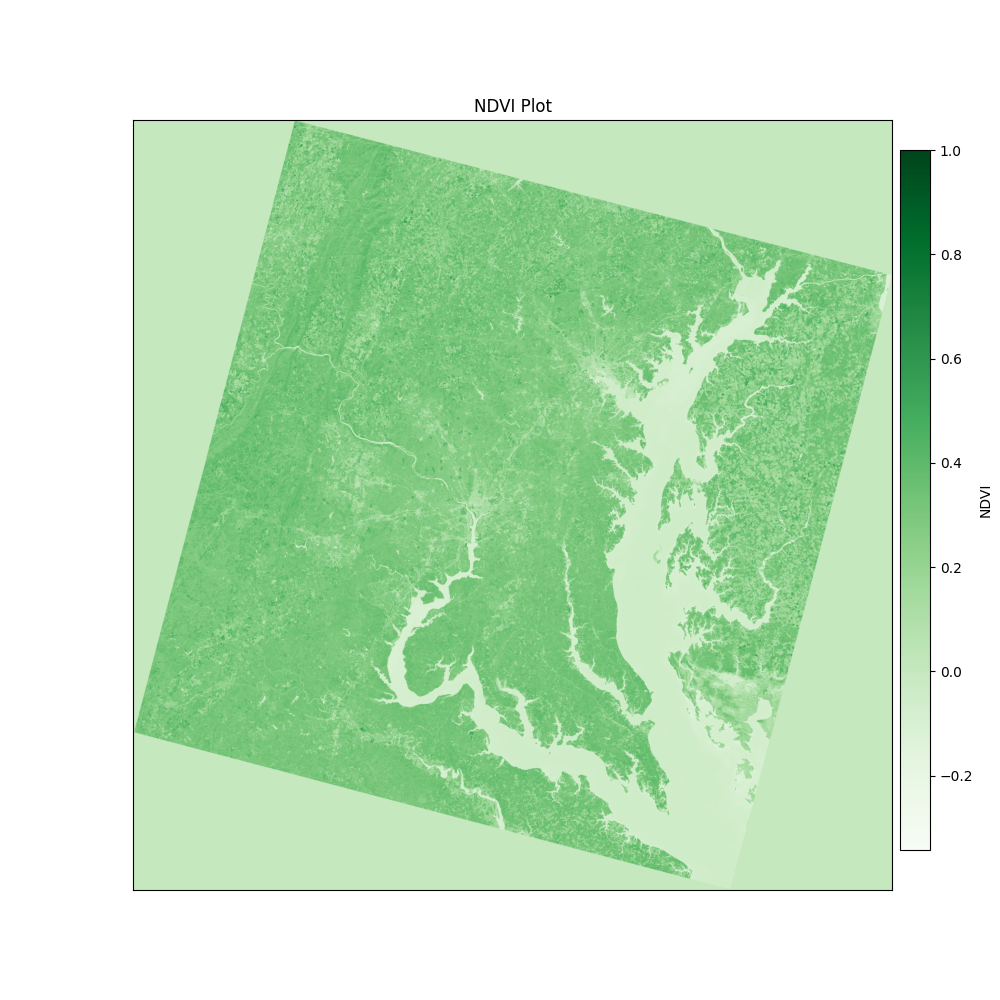

In [57]:
plot_png = subprocess.check_output(["ipfs", "cat", plot_img_hash])
img = pil_image.open(BytesIO(plot_png))
display(img)

### Pinning the plot image to IPFS for global access
It's the same plot we generated earlier, but this time it's stored on IPFS! 

It's important to note that the IPFS node we just wrote to and fetched from are on our local machine. This means that the data is only available to us. If we want to share the data with others, we will need to pin the data to a public IPFS node. We can do this by using the [ipfs pin add](https://docs.ipfs.io/reference/cli/#ipfs-pin-add) command.

In [60]:
subprocess.check_output(["ipfs", "pin", "add", plot_img_hash])

b'pinned QmbkCHHZJ3UoywA7DhnqFfBD6CVPUpFu7QajMg9Tp66JwL recursively\n'

After pinning the data to our local IPFS node, we can fetch it from any IPFS node worldwide using the same IPFS get command as before. However, keep in mind that download speeds will be influenced by the distance between your computer and the requester's location, as well as the internet connection speeds for both parties. To make your data more accessible, you can consider using a pinning service like [Pinata](https://www.pinata.cloud/) or managing the pinning yourself by setting up your own IPFS nodes.

## Conclusion
In this blog post, we demonstrated how to calculate NDVI on Landsat 9 imagery using IPFS in a Jupyter notebook. By leveraging IPFS in place of traditional storage systems, we can benefit from content-addressing and decentralization. These features lead to faster data access, improved data persistence, and more efficient storage, highlighting the potential of IPFS in geospatial workflows.

## Bonus - Want to make the data even more accessible?
If you would like to make the dataset we used in this tutorial more accessible, you can add the two landsat bands to your IPFS node using the following commands. Make sure you have run the earlier cells that downloaded the landsat bands into the variables `red_band` and `nir_band` before running these commands.

In [61]:
result_red = subprocess.run(["ipfs", "add", "-", "--pin=true"], input=red_band, capture_output=True)
result_nir = subprocess.run(["ipfs", "add", "-", "--pin=true"], input=nir_band, capture_output=True)

You can use the `ipfs ls` command to confirm that the two Landsat bands and the plot have been added to your IPFS node. By pinning the data, you have made it accessible to the IPFS network, allowing others to access it as well. By sharing this data on IPFS, you are contributing to the open and decentralized web, and making it easier for others to access and use this data. Perhaps the next person following this tutorial will obtain the data from your IPFS node!

In [62]:
pinned_files = subprocess.run(["ipfs", "pin", "ls", "--type=recursive"], capture_output=True)

print(pinned_files.stdout.decode())

QmbkCHHZJ3UoywA7DhnqFfBD6CVPUpFu7QajMg9Tp66JwL recursive
QmQPeNsJPyVWPFDVHb77w8G42Fvo15z4bG2X8D2GhfbSXc recursive
QmTgttqUf7PvZgdSoe71j3njeEKk1hC3h22n2sQmety3To recursive
QmZkWaKSuVhFKtAwNbxSogcT6hXHMksXjhgqLu6AXHSUKq recursive
Qmb1CYiG5Bc9FHDv47ZYPzQ6GuPDydXfxKVRBjKcMayosN recursive



## Footnotes
¹ The IPFS node may not actually be the closest node to you. But is simply the one that is most capable of serving the data. This is because IPFS nodes are not required to be online 24/7 and have various levels of bandwidth and storage capacity.